# Algorithm 1: Performative Risk Control

### Set up

In [172]:
# Experimental setup arguments

class args:
    alpha = 0.2         # risk control level
    tightness = 0.12    # tightness parameter, may throw error if too low
    delta = 0.1         # failure probability or confidence parameter

    tau = 1.            # safety parameter
    L = 5              # Lipschitz constant

    #gamma = 0.001        # sensitivity constant, must be <= tau / L from the theory

    N = 3000            # number of samples in cohort

    lambda_max = 1.0    # maximum value for lambda

    ell_max = 1.0

    # To calculate after the first round
    # delta_lambda      # max difference in lambda between consecutive rounds to guarantee tightness
    # T                 # number of rounds needed for theoretical guarantee
    # sigma_sq          # upper bound on variance on any distributional parameter lambda
    # M             # upper bound on the PDF of the initial data distribution

In [5]:
# %load_ext autoreload
# %autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [6]:
import os
os.chdir(r'C:\Users\chenbt\Downloads\rcpp-main\rcpp-main\GiveMeSomeCredit')

In [9]:
from data_prep import load_data
np.random.seed(42)

#path_to_csv_file = './data/cs-training.csv'
path_to_csv_file = './cs-training.csv'
X_all, Y_all, data = load_data(path_to_csv_file)

d = X_all.shape[1] - 1
print('d=',d)

# Total number of samples
total_samples = X_all.shape[0]

# First: split off 3000 for training
X_train, X_temp, Y_train, Y_temp = train_test_split(
    X_all, Y_all, train_size=3000, random_state=42
)


# Clean up
del X_all, Y_all

d= 10


In [11]:
# strategic feature indices
strat_features = np.array([1, 6, 8]) - 1 # for later

print('Strategic Features: \n')
for i, feature in enumerate(strat_features):
    print(i, data.columns[feature + 1])

# # zero out non-strategic features
# assert model.coef_.shape == (1, d+1) 
# strat_coef = np.zeros((1, d+1))
# strat_coef[0, strat_features] = model.coef_[0, strat_features]

Strategic Features: 

0 RevolvingUtilizationOfUnsecuredLines
1 NumberOfOpenCreditLinesAndLoans
2 NumberRealEstateLoansOrLines


[[ 0.07021367 -0.37790385  1.38865649 -0.31126216 -0.69039597  0.02952907
   1.01885607  0.11360131 -0.89831213  0.16047303 -0.43313032]]


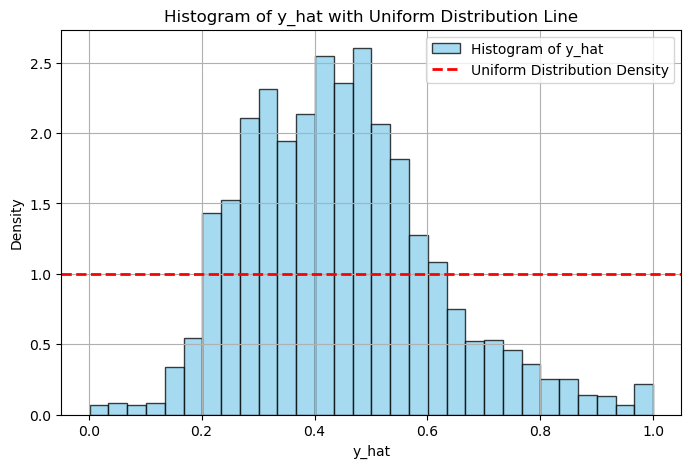

In [13]:
def train_logistic_regression(X, Y, **kwargs):
    # fit_intercept=False since X already has bias term
    model = LogisticRegression(fit_intercept=False, **kwargs)  # intercept pre-built in X
    model.fit(X, Y)
    assert model.classes_[0] == 0 and model.classes_[1] == 1
    return model

model = train_logistic_regression(X_train, Y_train)
# example_thresh = 0.5
# Y_proba = model.predict_proba(X_train)[:,1]
# Y_pred = Y_proba > example_thresh
print(model.coef_)
Y_hat = model.predict_proba(X_train)[:,1]


# Assuming y_hat is already defined and contains values between 0 and 1
# Example: y_hat = np.random.uniform(0, 1, N)

plt.figure(figsize=(8, 5))

# Plot histogram of y_hat
counts, bins, _ = plt.hist(Y_hat, bins=30, density=True, color='skyblue', edgecolor='black', alpha=0.75, label='Histogram of y_hat')

# Overlay horizontal line for uniform distribution
plt.axhline(y=1, color='red', linestyle='--', linewidth=2, label='Uniform Distribution Density')

# Labels and legend
plt.xlabel('y_hat')
plt.ylabel('Density')
plt.title('Histogram of y_hat with Uniform Distribution Line')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

# Compute M: Upper bound of the PDF
M= counts.max()

In [75]:
def hoeffding_bound(T, epsilon, n):

    delta_prime = (args.delta * args.tau * epsilon) / (T * args.alpha)
    return args.ell_max * np.sqrt((1 / (2 * n)) * np.log(2 / delta_prime))

In [140]:
# Hoeffding-benktus bound
from scipy.stats import binom

# define the KL divergence for h1(a,b)
def h1(a, b):
    if a == 0 or a == 1 or b == 0 or b == 1:
        return 0
    return a * np.log(a / b) + (1 - a) * np.log((1 - a) / (1 - b))

# define the Bentkus p-value function for one side
def bentkus_p_value(N, R_hat, beta):
    term1 = np.exp(-N * h1(min(R_hat, beta), beta))
    term2 = binom.cdf(np.floor(N * R_hat), N, beta)
    return min(term1, term2)

type_ii_errors = ((Y_train == 1) & (Y_hat < 0.5)).astype(int)
args.L_hat = np.mean(type_ii_errors)

def hoeffding_bentkus_bound(T, epsilon, n, L_hat):
    delta_prime = (args.delta * args.tau * epsilon) / (T * args.alpha)
    # Search for the smallest c >= 0 such that both p-values sum to <= delta_prime
    def total_pval(c):
        p_ub = bentkus_p_value(n, L_hat, L_hat + c)
        p_lb = bentkus_p_value(n, 1 - L_hat, 1 - (L_hat - c))
        return p_ub + p_lb

    # Binary or grid search to find smallest c such that total_pval(c) <= delta_prime
    c_min, c_max = 0.0, 1.0
    tol = 1e-6
    while c_max - c_min > tol:
        c_mid = (c_min + c_max) / 2
        if total_pval(c_mid) <= delta_prime:
            c_max = c_mid
        else:
            c_min = c_mid
    return c_max

In [150]:
# Estimate sigma, the variance of the loss
#sigma_sq_base = np.var(Y_hat, ddof=1)
#args.sigma_sq = 2 * sigma_sq_base

# Binary predictions (e.g., threshold at 0.5)
#Y_pred = (Y_hat >= 0.5).astype(int)
#type_ii_errors = ((Y_train == 1) & (Y_pred == 0)).astype(int)
# Estimate variance of type II error across data points
args.sigma_sq = np.var(type_ii_errors, ddof=1)  # Use ddof=1 for unbiased estimate
print(f"Estimated sigma squared: {args.sigma_sq}")

def bernstein_bound(T, epsilon, n):
    delta_prime = (args.delta * args.tau * epsilon) / (T * args.alpha)

    return np.sqrt(4 * args.sigma_sq * np.log( 2/ delta_prime) / n) + \
        (2 * args.lambda_max * np.log(2 / delta_prime)) / (3 * n)

Estimated sigma squared: 0.16498555073913523


In [152]:
# CLT bound

from scipy.stats import norm
 
args.sigma = np.sqrt(args.sigma_sq)

def clt_bound(T, epsilon, n):
    delta_prime = (args.delta * args.tau * epsilon) / (T * args.alpha)
    z = norm.ppf(1 - delta_prime / 2)  # two-sided
    return z * args.sigma / np.sqrt(n)

In [118]:
def satisfies_risk_control(epsilon, n, bound):
    """
    Checks if the risk control inequality holds for a given epsilon.
    """
    T = int(1 + (args.lambda_max / epsilon)) 
    disc_error = (args.tau + args.L) * epsilon

    # Choose the generalization bound
    if bound == "hoeffding":
        gen_error = 2 * hoeffding_bound(T, epsilon, n)
    elif bound == "hoeffding_bentkus":
        gen_error = 2 * hoeffding_bentkus_bound(T, epsilon, n, args.L_hat)
    elif bound == "clt":
        gen_error = 2 * clt_bound(T, epsilon, n)
    elif bound == "bernstein":
        gen_error = 2 * bernstein_bound(T, epsilon, n)
    else:
        raise ValueError(f"Unknown bound_type: {bound_type}")

    return disc_error + gen_error <= args.tightness

def find_largest_feasible_epsilon(n, bound, tol=1e-5):
    eps_low, eps_high = 1e-6, 1.0
    best_eps = 0.0

    while eps_high - eps_low > tol:
        mid = (eps_low + eps_high) / 2
        if satisfies_risk_control(mid, n, bound):
            best_eps = mid
            eps_low = mid
        else:
            eps_high = mid

    return best_eps

#epsilon = find_largest_feasible_epsilon(args.N, bound="bernstein")
#print(f"Largest feasible ε: {epsilon:.6f}")

def construct_epsilon_net(epsilon, lambda_max):
    if epsilon <= 0:
        raise ValueError("epsilon must be positive.")
    
    num_points = int(1 / epsilon) + 1
    return [k * epsilon * lambda_max for k in range(num_points)]

#epsilon_net = construct_epsilon_net(epsilon, args.lambda_max)
#print("Epsilon-net:", epsilon_net)
#T = int(1 + (args.lambda_max / epsilon)) 

# Experiment

In [24]:
def type_II_error(Y, Y_proba, threshold):
    """Y=actual, Y_proba=predicted probability, threshold=threshold"""
    return np.mean((Y == 1) * (Y_proba < 1. - threshold))


def piecewise_fn(Y_proba: np.ndarray, thresh: int):
    # clipping assumes loss btwn 0 and 1

    # lower_bound = (1 - thresh) - 1 / args.L
    # upper_bound = 1 - thresh
    # y = np.where(Y_proba < lower_bound, 1, 
    #              np.where(Y_proba > upper_bound, 0, 
    #                       1 - args.L * (Y_proba - (1 - thresh) + 1 / args.L)))

    # Optimization 1: use np.clip
    assert len(Y_proba.shape) == 1
    return np.clip(1. - args.L * (Y_proba - (1 - thresh)), 0, 1)

    # Optimization 2: compute less
    #assert len(Y_proba.shape) == 1
    #return np.clip(args.L * (1 - thresh - Y_proba), 0, 1)


def piecewise_loss(Y, Y_proba, thresh):
    assert len(Y.shape) == 1
    assert len(Y_proba.shape) == 1
    return ((Y == 1) * piecewise_fn(Y_proba, thresh))

def modify(Y_proba, threshold):
    shift = args.gamma / M
    condition = (1 - threshold) < (Y_proba - shift)

    Y_proba_new = Y_proba.copy()
    Y_proba_new[~condition] -= shift
    Y_proba_new = np.clip(Y_proba_new, 0, 1)

    return Y_proba_new

In [156]:
from tqdm import tqdm

def run_trajectory(Y, Y_proba, bound_type, verbose=False):

    epsilon = find_largest_feasible_epsilon(args.N, bound_type)
    epsilon_net = construct_epsilon_net(epsilon, args.lambda_max)
    args.T = int(1 + (args.lambda_max / epsilon)) 
    
    # Precompute Hoeffding generalization bound
    if bound_type == "hoeffding":
        args.bound = hoeffding_bound(args.T, epsilon, args.N)
    elif bound_type == "hoeffding_bentkus":
        args.bound = hoeffding_bentkus_bound(args.T, epsilon, args.N, args.L_hat)
    elif bound_type == "clt":
        args.bound = clt_bound(args.T, epsilon, args.N)
    elif bound_type == "bernstein":
        args.bound = bernstein_bound(args.T, epsilon, args.N)
    else:
        raise ValueError(f"Unknown bound_type: {bound_type}")

    # Initialization
    thresh = args.lambda_max
    threshes = [thresh]

    # Metrics at λ_t
    loss_at_lambda_t = []
    err_at_lambda_t = []

    # Metrics at λ_{t+1} under D(λ_t)
    loss_at_lambda_tp1 = []
    err_at_lambda_tp1 = []

    iters = tqdm(range(1, args.T + 1)) if verbose else range(1, args.T + 1)

    for t in iters:
        # Step 1: Apply performative modification
        Y_proba_t = modify(Y_proba, thresh)

        # Step 2: Evaluate loss and type II error
        loss_t = float(np.mean(piecewise_loss(Y, Y_proba_t, thresh)))
        err_t = float(type_II_error(Y, Y_proba_t, thresh))
        loss_at_lambda_t.append(loss_t)
        err_at_lambda_t.append(err_t)

        # Step 3: Filter ε-net to candidates below current threshold
        valid_threshes = []
        for lam in epsilon_net:
            if lam < thresh:
                risk = np.mean(piecewise_loss(Y, Y_proba_t, lam)) \
                       + args.tau * (thresh - lam) \
                       + args.bound
                if risk <= args.alpha:
                    valid_threshes.append(lam)

        # Step 4: If no valid thresholds, return
        if len(valid_threshes) == 0:
            valid_threshes.append(thresh)

        # Step 5: Greedy update to smallest valid lambda
        new_thresh = min(valid_threshes)
        loss_tp1 = float(np.mean(piecewise_loss(Y, Y_proba_t, new_thresh)))
        err_tp1 = float(type_II_error(Y, Y_proba_t, new_thresh))

        # Log simulated lookahead metrics
        loss_at_lambda_tp1.append(loss_tp1)
        err_at_lambda_tp1.append(err_tp1)
        #print(f"Iter {t}: Loss: {loss_t:.4f}, Type II error: {err_t:.4f}, "
        #      f"Threshold: {thresh:.4f}, New Threshold: {new_thresh:.4f}")

        thresh = new_thresh
        threshes.append(thresh)

    return {
        "loss_at_lambda_t": loss_at_lambda_t,
        "err_at_lambda_t": err_at_lambda_t,
        "loss_at_lambda_tp1": loss_at_lambda_tp1,
        "err_at_lambda_tp1": err_at_lambda_tp1,
        "threshes": threshes
    }

### Run

### plot 1: change gamma, i.e. magnitude of distribution shift

In [175]:
X_cal, X_test, Y_cal, Y_test = train_test_split(
    X_temp, Y_temp, train_size=10000, random_state=42
)
Y_proba = model.predict_proba(X_cal)[:,1]

In [177]:
gammas = [0.01, 0.1, 0.2, 0.4, 1]
results_1 = {}

for gamma in gammas:
    args.gamma = gamma

    # Run PRC
    output = run_trajectory(Y_cal, Y_proba, "hoeffding")

    results_1[gamma] = {
        "loss_at_lambda_t": output["loss_at_lambda_t"],
        "loss_at_lambda_tp1": output["loss_at_lambda_tp1"],
        "err_at_lambda_t": output["err_at_lambda_t"],
        "err_at_lambda_tp1": output["err_at_lambda_tp1"],
        "threshes": output["threshes"],
    }

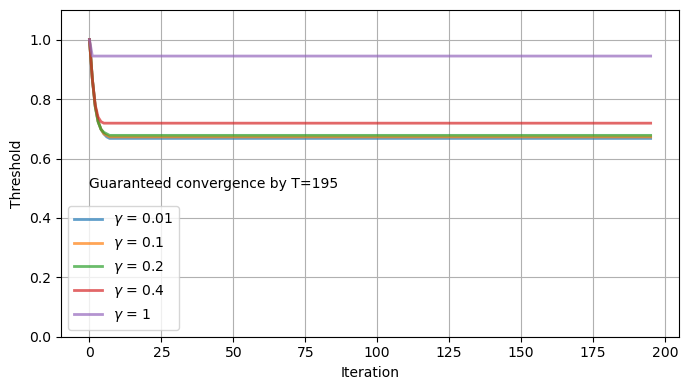

In [178]:
plt.figure(figsize=(7, 4))
plt.ylim(0, args.lambda_max)

colors = ['b', 'green', 'red', 'orange', 'black']
#gammas = [0.001, 0.01, 0.1, 0.2]

for gamma in gammas:
    plt.plot(results_1[gamma]["threshes"], label=rf"$\gamma$ = {gamma}", alpha=0.7, linewidth=2)

plt.xlabel('Iteration')
plt.ylabel('Threshold')
plt.ylim(0,1.1)
plt.text(0, 0.5, f"Guaranteed convergence by T={args.T}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

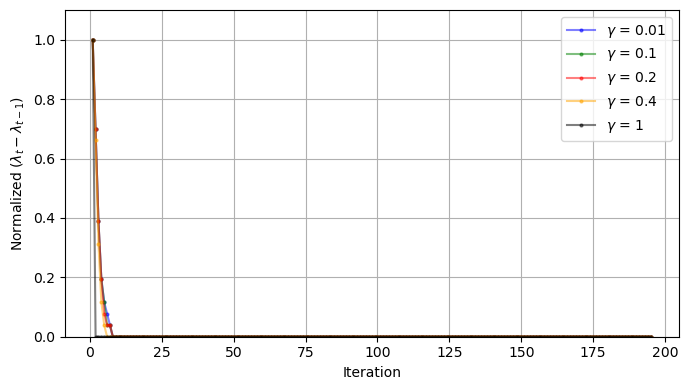

In [183]:
plt.figure(figsize=(7, 4))

colors = ['b', 'g', 'red', 'orange', 'black']

for gamma, color in zip(gammas, colors):
    threshes = results_1[gamma]["threshes"]
    # Compute squared diffs between successive thresholds
    diffs = [(threshes[i] - threshes[i - 1]) for i in range(1, len(threshes))]
    
    # Normalize to start from 1
    if diffs:
        normalized_diffs = [diff / diffs[0] for diff in diffs]
        plt.plot(range(1, len(threshes)), normalized_diffs, marker='o', markersize=2,
                 label=rf"$\gamma$ = {gamma}", color=color, alpha = 0.5)

plt.xlabel('Iteration')
plt.ylabel(r'Normalized $(\lambda_t - \lambda_{t-1})$')
plt.ylim(0,1.1)
#plt.title('Normalized Squared Threshold Differences')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### plot 2: Plot risk level vs. num of iter. $E_{D(\lambda_t)} l(\lambda_{t+1})$  (avg over 1000 trajectories+err bar). 

In [146]:
args.gamma = 0.2

In [87]:
num_runs = 10
all_losses_tp1 = []
all_errs_tp1 = []
all_losses_t = []
all_errs_t = []

all_accuracies_per_iter = []
all_threshes = None 

for seed in range(num_runs):
    # Step 1: Split calibration/test
    X_cal, X_test, Y_cal, Y_test = train_test_split(
        X_temp, Y_temp, train_size=10000, random_state=seed
    )

    # Step 2: Predict probabilities
    Y_proba_cal = model.predict_proba(X_cal)[:, 1]
    Y_proba_test = model.predict_proba(X_test)[:, 1]
    
    # Step 3: Run PRC
    results_2 = run_trajectory(Y_cal, Y_proba_cal, "hoeffding")

    # Save results
    all_losses_tp1.append(results_2["loss_at_lambda_tp1"])
    all_errs_tp1.append(results_2["err_at_lambda_tp1"])
    all_losses_t.append(results_2["loss_at_lambda_t"])
    all_errs_t.append(results_2["err_at_lambda_t"])

    # Step 5: Save threshold trajectory from the first run
    if all_threshes is None:
        all_threshes = results_2["threshes"]
    else:
        # Safety check: make sure all runs have the same threshold length
        assert len(results_2["threshes"]) == len(all_threshes), "Threshold trajectory length mismatch"

    # Step 6: Evaluate accuracy at each threshold
    accuracies = []
    for thresh in results_2["threshes"]:
        Y_proba_mod = modify(Y_proba_test, thresh)
        Y_pred = (Y_proba_mod >= thresh).astype(int)
        acc = np.mean(Y_pred == Y_test)
        accuracies.append(acc)

    all_accuracies_per_iter.append(accuracies)

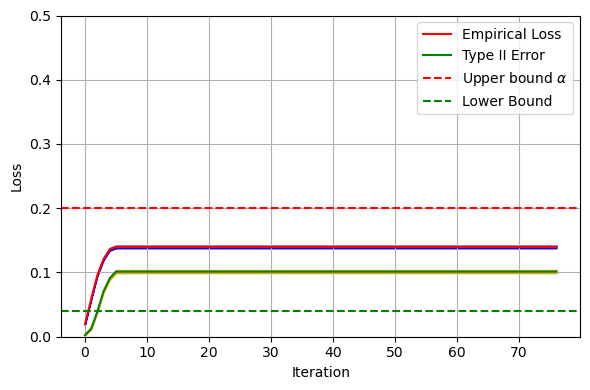

In [89]:
max_len = max(len(l) for l in all_losses_tp1)

loss_matrix = np.array([
    np.pad(l, (0, max_len - len(l)), constant_values=np.nan)
    for l in all_losses_tp1
])
err_matrix = np.array([
    np.pad(e, (0, max_len - len(e)), constant_values=np.nan)
    for e in all_errs_tp1
])

loss_mean = np.nanmean(loss_matrix, axis=0)
loss_std = np.nanstd(loss_matrix, axis=0)

err_mean = np.nanmean(err_matrix, axis=0)
err_std = np.nanstd(err_matrix, axis=0)

z = 1.645  # for ~90% confidence
loss_upper = loss_mean + z * loss_std
loss_lower = loss_mean - z * loss_std

err_upper = err_mean + z * err_std
err_lower = err_mean - z * err_std

plt.figure(figsize=(6, 4))

# Plot mean trajectories
plt.plot(loss_mean, color='red', label='Empirical Loss')
plt.plot(err_mean, color='green', label='Type II Error')

# Confidence bands
plt.fill_between(range(len(loss_mean)), loss_lower, loss_upper, color='b', alpha=1.0)
plt.fill_between(range(len(err_mean)), err_lower, err_upper, color='orange', alpha=1.0)

# Reference lines
plt.axhline(args.alpha, linestyle='--', color='red', label='Upper bound $\\alpha$')
plt.axhline(args.alpha - args.tightness, linestyle='--', color='green', label='Lower Bound')

plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.ylim(0, 0.5)
plt.legend()
#plt.title("One-Step Lookahead Risk & Error (90% CI)")
plt.grid(True)
plt.tight_layout()
plt.show()

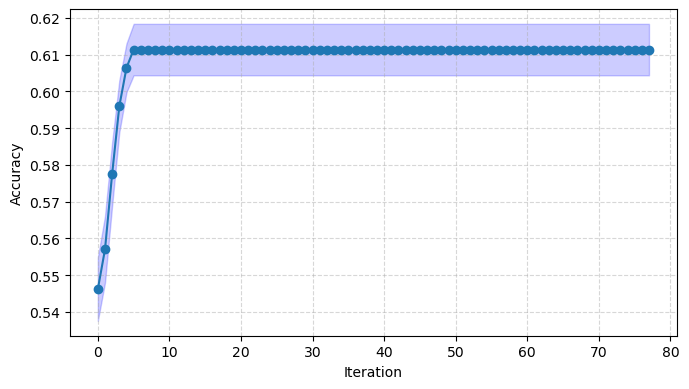

In [91]:
all_accuracies_per_iter = np.array(all_accuracies_per_iter)  # shape: (num_runs, num_thresholds)
mean_accuracies = np.mean(all_accuracies_per_iter, axis=0)
std_accuracies = np.std(all_accuracies_per_iter, axis=0)

# 90% confidence interval
z = 1.645
acc_upper = mean_accuracies + z * std_accuracies
acc_lower = mean_accuracies - z * std_accuracies

# Step 8: Plot average accuracy trajectory
plt.figure(figsize=(7, 4))
plt.plot(range(len(mean_accuracies)), mean_accuracies, marker='o')
plt.fill_between(range(len(mean_accuracies)), acc_lower, acc_upper, color='blue', alpha=0.2)

#plt.xticks(ticks=range(len(all_threshes)), labels=[f"{t:.3f}" for t in all_threshes], rotation=45)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
#plt.title("Average Accuracy Across Iterations (Thresholds)")
#plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### plot 3: Plot risk level vs. num of iter. $E_{D(\lambda_t)} l(\lambda_{t})$ (avg over 1000 trajectories+err bar)

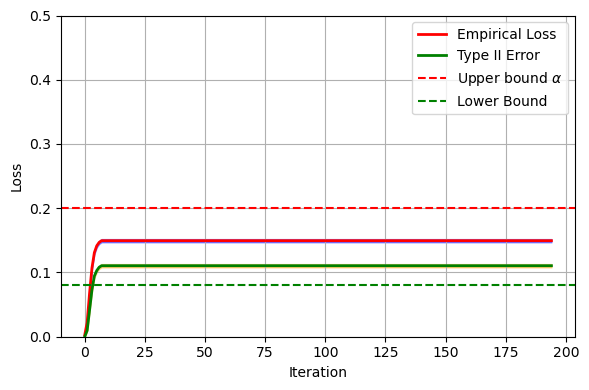

In [68]:
max_len = max(len(l) for l in all_losses_t)

# Pad to same length for aggregation
loss_matrix = np.array([
    np.pad(l, (0, max_len - len(l)), constant_values=np.nan)
    for l in all_losses_t
])
err_matrix = np.array([
    np.pad(e, (0, max_len - len(e)), constant_values=np.nan)
    for e in all_errs_t
])

# Compute mean and 90% confidence intervals
loss_mean = np.nanmean(loss_matrix, axis=0)
loss_std = np.nanstd(loss_matrix, axis=0)

err_mean = np.nanmean(err_matrix, axis=0)
err_std = np.nanstd(err_matrix, axis=0)

z = 1.645  # for ~90% confidence
loss_upper = loss_mean + z * loss_std
loss_lower = loss_mean - z * loss_std

err_upper = err_mean + z * err_std
err_lower = err_mean - z * err_std

# Plotting
plt.figure(figsize=(6, 4))

# Mean curves
plt.plot(loss_mean, color='red', label='Empirical Loss', linewidth=2)      
plt.plot(err_mean, color='green', label='Type II Error', linewidth=2)         

# Confidence bands
plt.fill_between(range(len(loss_mean)), loss_lower, loss_upper, color='blue', alpha=0.4)  
plt.fill_between(range(len(err_mean)), err_lower, err_upper, color='orange', alpha=0.4)    

# Reference bounds
plt.axhline(args.alpha, linestyle='--', color='red', label='Upper bound $\\alpha$')
plt.axhline(args.alpha - args.tightness, linestyle='--', color='green', label='Lower Bound')

# Labels and layout
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.ylim(0, 0.5)
plt.legend()
#plt.title("Performative Risk & Error at λ_t (90% CI)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Plot 4: We get for lambda_T actual value +- err and upper (alpha) and lower bound $E_{D(\lambda_T)}l (\lambda_T)$ 

In [48]:
def evaluate_prc_over_seeds(X_temp, Y_temp, bound_type, num_runs=10):
    all_test_losses = []
    all_test_errors = []
    all_final_thresholds = []

    for seed in range(num_runs):
        # Step 1: Split calibration/test
        X_cal, X_test, Y_cal, Y_test = train_test_split(
            X_temp, Y_temp, train_size=10000, random_state=seed
        )

        # Step 2: Predict probabilities
        Y_proba_cal = model.predict_proba(X_cal)[:, 1]
        Y_proba_test = model.predict_proba(X_test)[:, 1]

        # Step 3: Run PRC
        results_3 = run_trajectory(Y_cal, Y_proba_cal, bound_type)
        final_thresh = results_3["threshes"][-1]

        # Step 4: Evaluate on test set (simulate D(λ_T) using final_thresh) 
        Y_proba_test_mod = modify(Y_proba_test, final_thresh)

        # Step 5: Evaluate test loss and error under D(λ_T)
        test_loss = float(np.mean(piecewise_loss(Y_test, Y_proba_test_mod, final_thresh)))
        test_error = float(type_II_error(Y_test, Y_proba_test_mod, final_thresh))

        # Step 6: Store results
        all_test_losses.append(test_loss)
        all_test_errors.append(test_error)
        all_final_thresholds.append(final_thresh)

    # Compute statistics and bound
    losses = np.array(all_test_losses)
    errors = np.array(all_test_errors)

    return {
        "losses": losses,
        "errors": errors,
        "thresholds": all_final_thresholds
    }

In [38]:
results_3 = evaluate_prc_over_seeds(X_temp, Y_temp, bound_type="hoeffding")

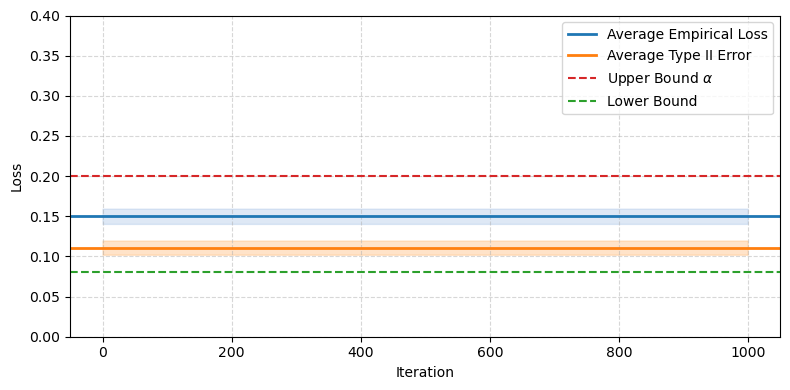

In [40]:
# Extract data from results
losses = results_3["losses"]
errors = results_3["errors"]

# Compute mean and std
loss_mean = np.mean(losses)
loss_std = np.std(losses, ddof=1)

error_mean = np.mean(errors)
error_std = np.std(errors, ddof=1)

# 90% confidence interval
z = 1.645
loss_upper = loss_mean + z * loss_std
loss_lower = loss_mean - z * loss_std

error_upper = error_mean + z * error_std
error_lower = error_mean - z * error_std

# Risk thresholds
alpha_line = args.alpha
tight_line = args.alpha - args.tightness

# Plotting
plt.figure(figsize=(8, 4))

# Loss with confidence band (dark blue line, light blue band)
plt.axhline(loss_mean, color='#1f77b4', label='Average Empirical Loss', linewidth=2)
plt.fill_between(range(len(losses)), loss_lower, loss_upper, color='#aec7e8', alpha=0.4)

# Error with confidence band (dark orange line, light orange band)
plt.axhline(error_mean, color='#ff7f0e', label='Average Type II Error', linewidth=2)
plt.fill_between(range(len(errors)), error_lower, error_upper, color='#ffbb78', alpha=0.4)

# Threshold lines
plt.axhline(alpha_line, linestyle='--', color='#d62728', label=r'Upper Bound $\alpha$', linewidth=1.5)  # red
plt.axhline(tight_line, linestyle='--', color='#2ca02c', label=r'Lower Bound', linewidth=1.5)  # green

# Aesthetics
#plt.title("Mean Test Loss and Type II Error with 90% Confidence")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.ylim(0,0.4)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Table: Compare $B (N,\delta’)$, i.e. the union bound obtained by different upper bounding techniques

In [162]:
bounds = {
    "hoeffding": hoeffding_bound,
    #"hoeffding_bentkus": hoeffding_bentkus_bound,
    "clt": clt_bound,
    "bernstein": bernstein_bound
}

for name, bound_fn in bounds.items():
    results = evaluate_prc_over_seeds(X_temp, Y_temp, name)
    
    losses = results["losses"]
    errors = results["errors"]
    
    loss_shifted = losses + args.bound
    err_shifted = errors + args.bound

    # Print results
    print(f"{name} Bound - Test Loss: mean = {np.mean(loss_shifted):.4f}, std = {np.std(loss_shifted):.4f}")
    print(f"{name} Bound - Type II Error: mean = {np.mean(err_shifted):.4f}, std = {np.std(err_shifted):.4f}")
    print("-" * 60)

hoeffding Bound - Test Loss: mean = 0.1896, std = 0.0021
hoeffding Bound - Type II Error: mean = 0.1506, std = 0.0025
------------------------------------------------------------
clt Bound - Test Loss: mean = 0.1871, std = 0.0057
clt Bound - Type II Error: mean = 0.1472, std = 0.0055
------------------------------------------------------------
bernstein Bound - Test Loss: mean = 0.1930, std = 0.0036
bernstein Bound - Type II Error: mean = 0.1540, std = 0.0039
------------------------------------------------------------


In [ ]:
import numpy as np

losses = np.array(all_test_losses)
errors = np.array(all_test_errors)

# Compute statistics
loss_mean = np.mean(losses)
loss_var = np.var(losses, ddof=1)
error_mean = np.mean(errors)
error_var = np.var(errors, ddof=1)

loss_bound = hoeffding_bound_eval(num_runs, args.delta)
error_bound = hoeffding_bound_eval(num_runs, args.delta)

# Report
print(f"Loss: mean = {loss_mean:.4f}, var = {loss_var:.4f}, mean + B(N,δ) = {loss_mean + loss_bound:.4f}")
print(f"Error: mean = {error_mean:.4f}, var = {error_var:.4f}, mean + B(N,δ) = {error_mean + error_bound:.4f}")

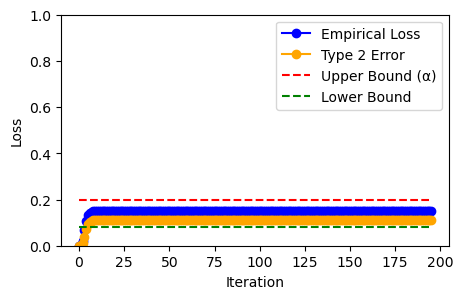

In [73]:
# Plot loss trajectory

upper_bound = [args.alpha for _ in range(len(losses))]
lower_bound = [args.alpha - args.tightness for _ in range(len(losses))]

#print(losses)
#print(upper_bound)
#print(lower_bound)

plt.figure(figsize=(5, 3))
plt.plot(losses, marker='o', linestyle='-', color='b', label='Empirical Loss')
plt.plot(errs, marker='o', linestyle='-', color='orange', label='Type 2 Error')
plt.plot(upper_bound, linestyle='--', color='r', label='Upper Bound (α)')
plt.plot(lower_bound, linestyle='--', color='g', label='Lower Bound')
plt.ylim(0, 1)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluation on the test set

In [81]:
# Use the threshold for test set

final_thresh = threshes[-1]
Y_proba_test = model.predict_proba(X_test)[:,1]
Y_proba_test_mod = modify(Y_proba_test, final_thresh)
test_loss = float(np.mean(piecewise_loss(Y_test, Y_proba_test_mod, final_thresh)))
test_error = float(type_II_error(Y_test, Y_proba_test_mod, final_thresh))

In [83]:
print(f"Final threshold: {final_thresh:.4f}")
print(f"Test loss: {test_loss:.4f}")
print(f"Test Type II error: {test_error:.4f}")

Final threshold: 0.6779
Test loss: 0.1519
Test Type II error: 0.1127


### 1000 runs

In [85]:
# 1000 runs with different splits

num_runs = 1000
all_test_losses = []
all_test_errors = []
all_final_thresholds = []

for seed in range(num_runs):
    # Step 1: Split calibration/test
    X_cal, X_test, Y_cal, Y_test = train_test_split(
        X_temp, Y_temp, train_size=10000, random_state=seed
    )

    # Step 2: Predict probabilities
    Y_proba_cal = model.predict_proba(X_cal)[:, 1]
    Y_proba_test = model.predict_proba(X_test)[:, 1]

    # Step 3: Run PRC
    losses, threshes, errs = run_trajectory(Y_cal, Y_proba_cal, epsilon_net)
    final_thresh = threshes[-1]

    # Step 4: Evaluate on test set
    Y_proba_test_mod = modify(Y_proba_test, final_thresh)
    test_loss = float(np.mean(piecewise_loss(Y_test, Y_proba_test_mod, final_thresh)))
    test_error = float(type_II_error(Y_test, Y_proba_test_mod, final_thresh))

    # Step 5: Store results
    all_test_losses.append(test_loss)
    all_test_errors.append(test_error)
    all_final_thresholds.append(final_thresh)

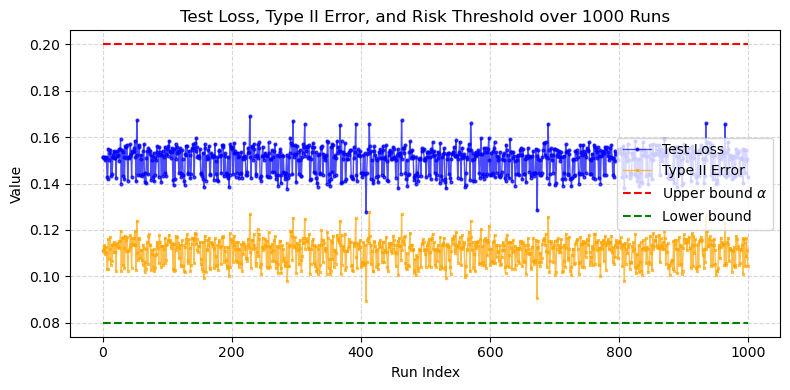

In [89]:
losses = np.array(all_test_losses)
errors = np.array(all_test_errors)
alphas = np.full_like(losses, args.alpha)
tightness = np.full_like(losses, args.alpha - args.tightness)

# Create the plot
plt.figure(figsize=(8, 4))
plt.plot(losses, label='Test Loss', color='blue', alpha=0.7, marker='o', markersize=2, linewidth=1)
plt.plot(errors, label='Type II Error', color='orange', alpha=0.7, marker='x', markersize=2, linewidth=1)
plt.plot(alphas, label=r'Upper bound $\alpha$', color='red', linestyle='--')
plt.plot(tightness, label=r'Lower bound', color='green', linestyle='--')

plt.title("Test Loss, Type II Error, and Risk Threshold over 1000 Runs")
plt.xlabel("Run Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()